In [2]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from utils.data import COCOAEDataset, collate_fn
from utils.transforms import get_transform
from utils.transforms import ResizeTransform
from noise.scheduler import NoiseScheduler, LinearMaskScheduler, mask_image
# import numpy as np

%load_ext autoreload
%autoreload 2

c:\Users\Rodrigo\.conda\envs\dl-final-sp2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = COCOAEDataset(root="coco/images/train2017/",
                        annFile="coco/annotations/ann2017/captions_train2017.json",
                        transform=get_transform(),
                        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased', cache_dir='cache/'),
                        ignore_cache=False,
                        train=True)

Loading cached annotations...


In [4]:
dataloader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        collate_fn=collate_fn(dataset.tokenizer.pad_token_id),
                        pin_memory=True)

noise_scheduler = LinearMaskScheduler(vocab_size=len(dataset.tokenizer))

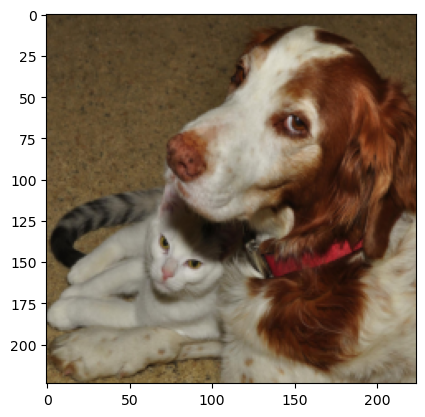

Permutations tensor([[148, 163, 159, 143, 166, 108,  95,   9,  11,  59, 192,  60, 107, 102,
         142, 123, 153, 137,  45,   2,  29,  71,  55, 173, 133, 180, 135,  94,
           1,  89, 195,  57, 145, 175,  78, 131,  24, 132, 122,  47, 114,  99,
         182, 179, 193,  92,  43,  54,  77,  37,  88,  70, 167,   3,  15,  18,
          14,  22, 187, 130, 170,   0, 150,  69, 169,  52,  76,  21, 156,  48,
         100,  58, 154,  84, 140,  13, 110,  19, 113,  51, 104,  67, 105, 194,
         165, 126,  16, 129, 139, 147, 136,  56,  85, 162,  28,   8,  93,  80,
         158,  98,  50, 177, 111,  96,  79, 174, 119, 188, 117, 189,  33,  20,
         168,  23,   5, 190,  83, 181,  31,  32,  97,  64,  10, 172, 151, 152,
         121, 101,   4,  68,  36, 141, 146, 116,  73, 134, 191,   7,  44,  42,
          72,  12,  82, 178,  75,  35,  87, 138, 186,  40, 115, 160, 109, 184,
          25, 106, 164, 124, 128, 127,  91, 125,  39, 149,  66,   6,  74,  27,
         161,  63, 155, 112, 185,  38, 

ValueError: too many values to unpack (expected 2)

In [5]:
for images, captions in dataloader:
    plt.imshow(images[0].squeeze().permute(1, 2, 0).numpy())
    plt.show()
    masked_patches, masked_text, (mask_indices, _) = noise_scheduler.get_masked(images, captions, need_masks=True)
    print(masked_patches.shape)
    gathered = torch.zeros((masked_patches.shape[0], 196, masked_patches.shape[2])).scatter_(1, mask_indices.unsqueeze(-1).expand(mask_indices.shape[:2] + (768,)), masked_patches).permute(0, 2, 1)
    folded = torch.nn.functional.fold(gathered, (images.shape[-2:]), (16, 16), stride=(16, 16))
    print(folded.shape)
    plt.imshow(folded[0].squeeze().permute(1, 2, 0).numpy())
    plt.show()
    print(dataset.tokenizer.batch_decode(captions.squeeze()))
    print(dataset.tokenizer.batch_decode(masked_text.squeeze()))
    break